# Example 1.
# Generating In-Domain Samples and Optimising Karplus-Strong Coefficients with Gradient Descent

## Generating noise bursts, $f_0$ tracks and coefficients

### Plotter utility

In [18]:
import torch
import matplotlib.pyplot as plt

def plot_waveforms(
    signals,
    titles=None,
    labels=None,
    sample_rate=16000,
    figsize=(10, 2.5),
    sharex=True
):
    num_plots = len(signals)
    fig, axs = plt.subplots(num_plots, 1, figsize=(figsize[0], figsize[1] * num_plots), sharex=sharex)

    # Make axs iterable even if there's only one subplot
    if num_plots == 1:
        axs = [axs]

    for i, ax in enumerate(axs):
        subplot_signals = signals[i] if isinstance(signals[i], (list, tuple)) else [signals[i]]
        t = torch.arange(subplot_signals[0].numel()) / sample_rate

        for j, y in enumerate(subplot_signals):
            label = None
            if labels is not None:
                if isinstance(labels[0], (list, tuple)):
                    label = labels[i][j] if i < len(labels) and j < len(labels[i]) else None
                else:
                    label = labels[j] if j < len(labels) else None
            ax.plot(t, y.detach().cpu(), label=label)

        if titles and i < len(titles):
            ax.set_title(titles[i])
        ax.set_ylabel("Amplitude")
        if label:
            ax.legend()

    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()

### Noise Bursts

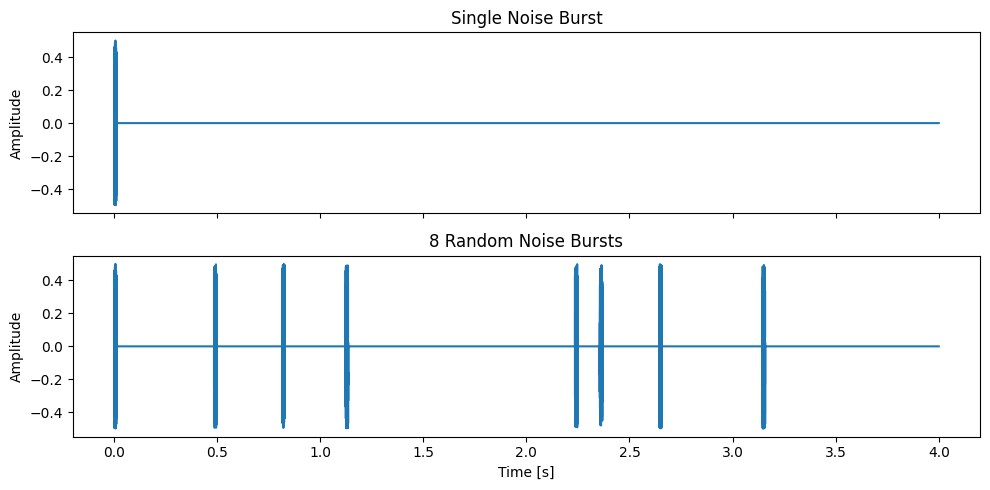

In [11]:
import random

torch.manual_seed(42)
random.seed(42)

SAMPLE_RATE = 16000
DURATION = 4.0
BURST_LENGTH_MS = 12.5

n_samples = int(SAMPLE_RATE * DURATION)
burst_length = int(SAMPLE_RATE * (BURST_LENGTH_MS / 1000.0))

# --- Generate bursts ---
burst_single = torch.zeros(n_samples)
burst_single[:burst_length] = torch.rand(burst_length) - 0.5

burst_multi = torch.zeros(n_samples)
positions = torch.randint(low=0, high=n_samples - burst_length, size=(7,)).tolist()

burst_multi += burst_single
for pos in positions:
    burst_multi[pos:pos + burst_length] += (torch.rand(burst_length) - 0.5)

# --- Plot using reusable function ---
plot_waveforms(
    signals=[burst_single, burst_multi],
    titles=["Single Noise Burst", "8 Random Noise Bursts"],
    sample_rate=SAMPLE_RATE
)

### $f_0$ tracks

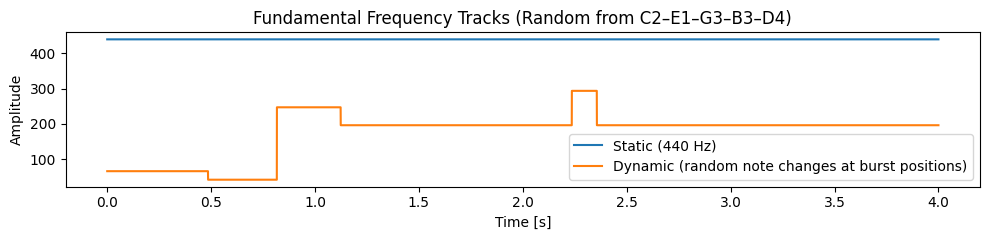

In [19]:
# --- F0 TRACKS (randomly chosen from C2–E1–G3–B3–D4) ---
note_freqs = torch.tensor([65.41, 41.20, 196.00, 246.94, 293.66])  # C2, E1, G3, B3, D4

f0_static = torch.full((n_samples,), 440.0)
f0_dynamic = torch.full((n_samples,), note_freqs[0])  # start with C2

# Randomly select note indices at each burst position
note_indices = torch.randint(0, len(note_freqs), (len(positions),))

# Ensure positions are sorted (important!)
positions = sorted(positions)

# Apply each note only until the next burst position
for i, (pos, idx) in enumerate(zip(positions, note_indices)):
    next_pos = positions[i + 1] if i + 1 < len(positions) else n_samples
    f0_dynamic[pos:next_pos] = note_freqs[idx]

# --- Plot using reusable function ---
plot_waveforms(
    signals=[[f0_static, f0_dynamic]],
    titles=["Fundamental Frequency Tracks (Random from C2–E1–G3–B3–D4)"],
    labels=[["Static (440 Hz)", "Dynamic (random note changes at burst positions)"]],
    sample_rate=SAMPLE_RATE
)

### Coefficients

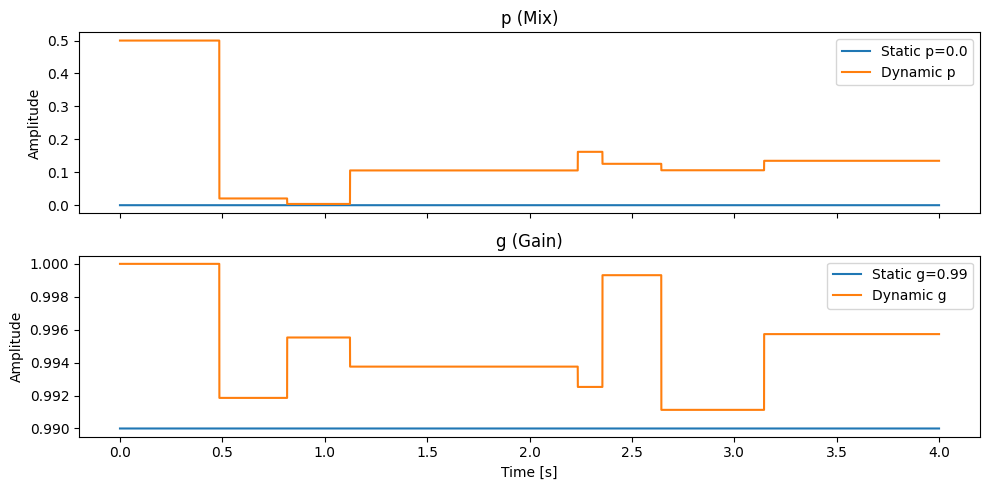

In [20]:
# Constant values
p_static = torch.full((n_samples,), 0.0)
g_static = torch.full((n_samples,), 0.99)

# Dynamic values initialized
p_dynamic = torch.full((n_samples,), 0.5)
g_dynamic = torch.full((n_samples,), 1.0)

# Generate random values at each burst position
random_p = 0.2 * torch.rand(len(positions))          # range [0, 0.2)
random_g = 0.99 + 0.01 * torch.rand(len(positions))  # range [0.99, 1.0)

# Ensure positions are sorted
positions = sorted(positions)

# Apply values between bursts instead of overwriting to the end
for i, (pos, p_val, g_val) in enumerate(zip(positions, random_p, random_g)):
    next_pos = positions[i + 1] if i + 1 < len(positions) else n_samples
    p_dynamic[pos:next_pos] = p_val
    g_dynamic[pos:next_pos] = g_val

# --- Plot using reusable function ---
plot_waveforms(
    signals=[[p_static, p_dynamic], [g_static, g_dynamic]],
    titles=["p (Mix)", "g (Gain)"],
    labels=[["Static p=0.0", "Dynamic p"], ["Static g=0.99", "Dynamic g"]],
    sample_rate=SAMPLE_RATE
)

## Karplus-Strong with FIR filter in loop

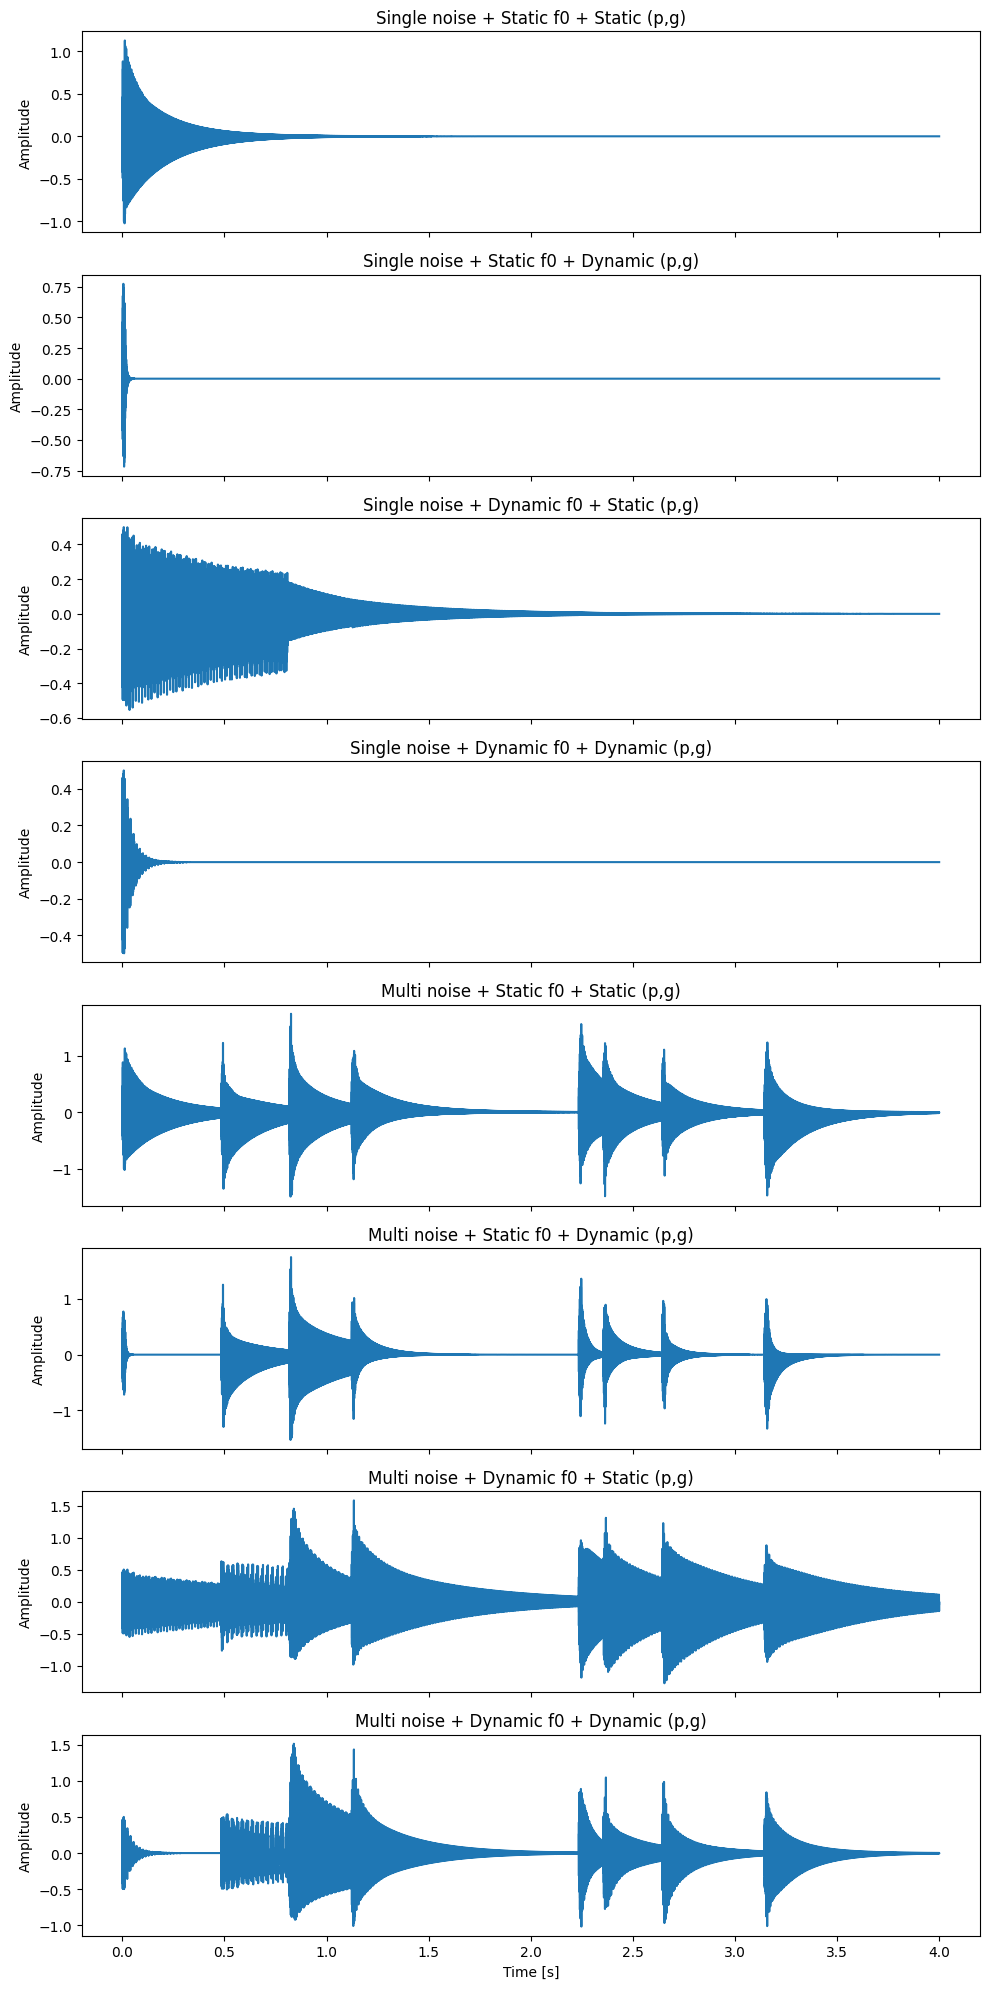


▶ Single noise + Static f0 + Static (p,g)



▶ Single noise + Static f0 + Dynamic (p,g)



▶ Single noise + Dynamic f0 + Static (p,g)



▶ Single noise + Dynamic f0 + Dynamic (p,g)



▶ Multi noise + Static f0 + Static (p,g)



▶ Multi noise + Static f0 + Dynamic (p,g)



▶ Multi noise + Dynamic f0 + Static (p,g)



▶ Multi noise + Dynamic f0 + Dynamic (p,g)


In [21]:
import warnings
warnings.filterwarnings("ignore", message="Custom extension not loaded")
warnings.filterwarnings("ignore", message="Cannot find custom extension")

from IPython.display import Audio
from ddsp.diff_ks import DiffKSFIRLoop

# --- Initialize model ---
fir_karplus = DiffKSFIRLoop()

# --- Prepare combinations: (noise, f0, (p, g)) ---
combinations = [
    (burst_single, f0_static, p_static, g_static, "Single noise + Static f0 + Static (p,g)"),
    (burst_single, f0_static, p_dynamic, g_dynamic, "Single noise + Static f0 + Dynamic (p,g)"),
    (burst_single, f0_dynamic, p_static, g_static, "Single noise + Dynamic f0 + Static (p,g)"),
    (burst_single, f0_dynamic, p_dynamic, g_dynamic, "Single noise + Dynamic f0 + Dynamic (p,g)"),
    (burst_multi, f0_static, p_static, g_static, "Multi noise + Static f0 + Static (p,g)"),
    (burst_multi, f0_static, p_dynamic, g_dynamic, "Multi noise + Static f0 + Dynamic (p,g)"),
    (burst_multi, f0_dynamic, p_static, g_static, "Multi noise + Dynamic f0 + Static (p,g)"),
    (burst_multi, f0_dynamic, p_dynamic, g_dynamic, "Multi noise + Dynamic f0 + Dynamic (p,g)"),
]

# --- Generate outputs ---
outputsFIR = []
for noise, f0, p_track, g_track, title in combinations:
    f0_tensor = (SAMPLE_RATE / f0).unsqueeze(0)
    input_tensor = noise.unsqueeze(0)
    l_b = torch.stack([g_track, p_track], dim=-1).unsqueeze(0)
    with torch.no_grad():
        y = fir_karplus(f0=f0_tensor, input=input_tensor, l_b=l_b)[0]
    outputsFIR.append((title, y))

# --- Plot using reusable function ---
plot_waveforms(
    signals=[y for _, y in outputsFIR],
    titles=[title for title, _ in outputsFIR],
    sample_rate=SAMPLE_RATE
)

# --- Play sounds ---
for title, y in outputsFIR:
    print(f"\n▶ {title}")
    display(Audio(y.cpu(), rate=SAMPLE_RATE))

## Karplus-Strong with IIR filter in loop


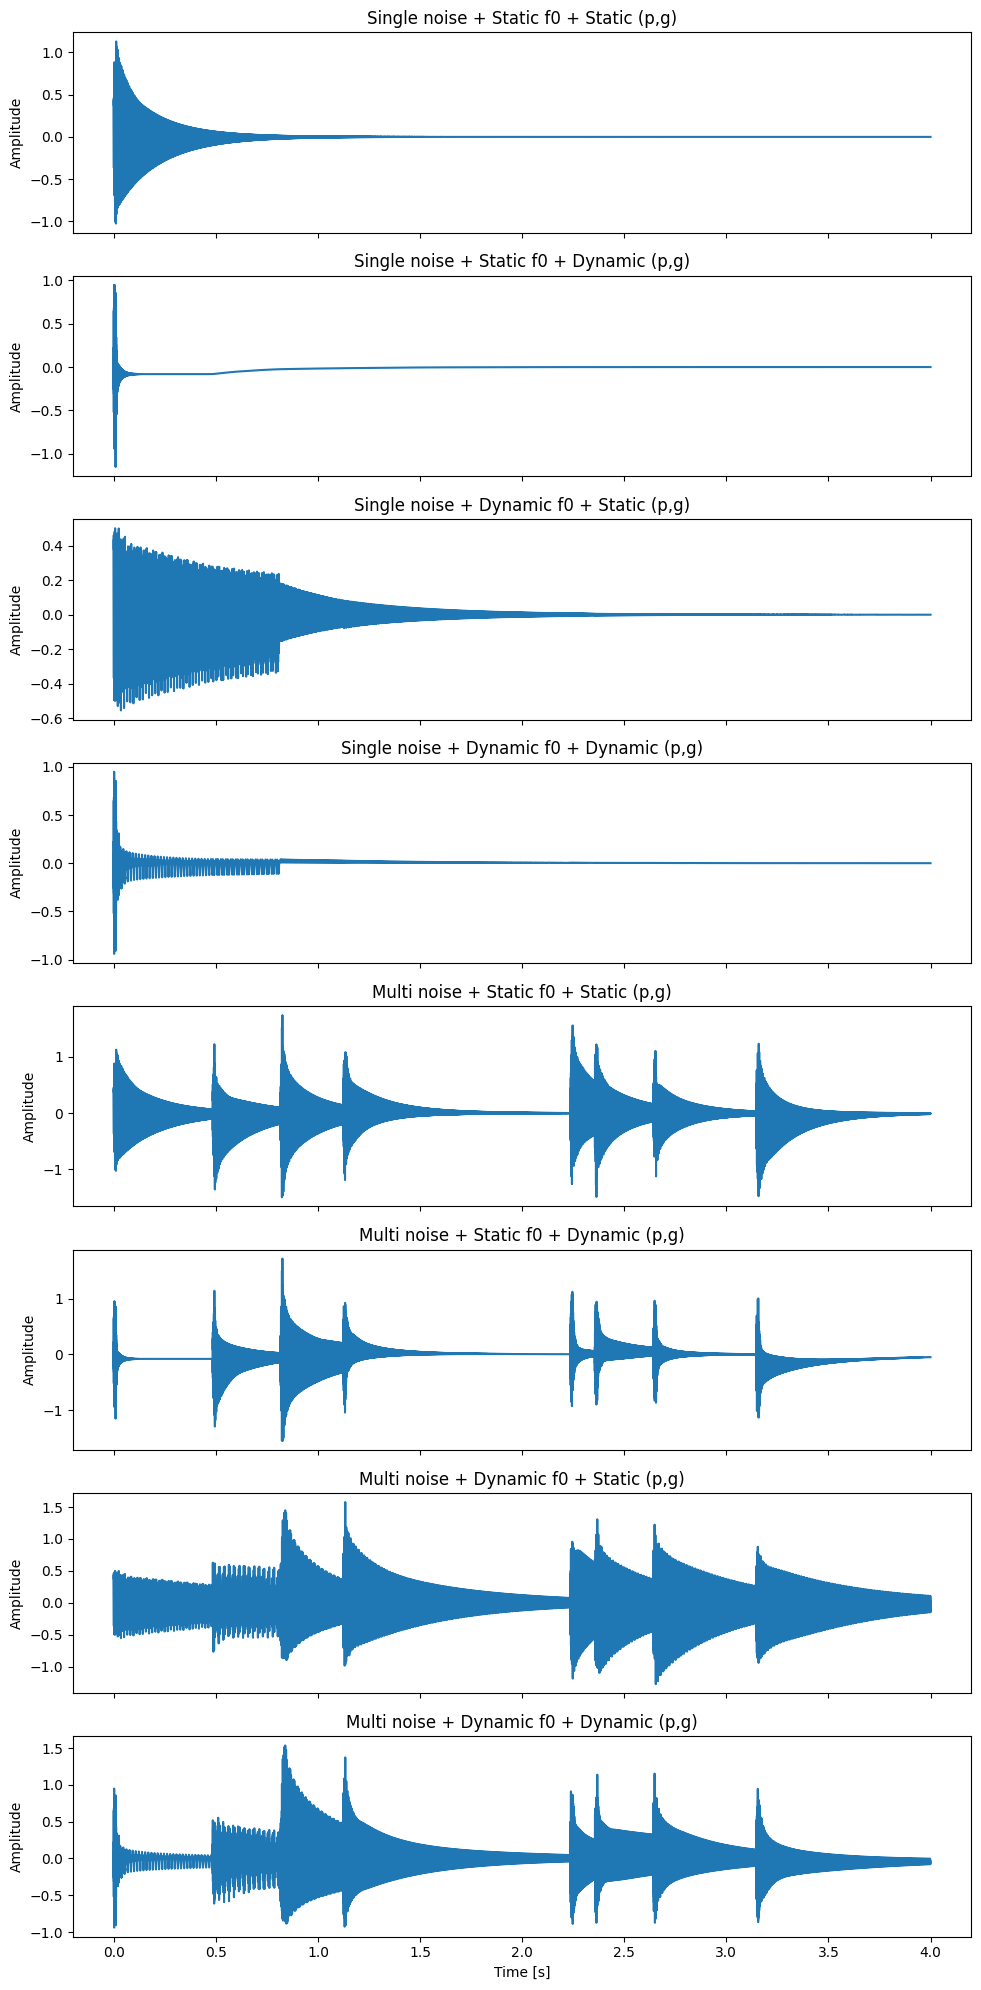


▶ Single noise + Static f0 + Static (p,g)



▶ Single noise + Static f0 + Dynamic (p,g)



▶ Single noise + Dynamic f0 + Static (p,g)



▶ Single noise + Dynamic f0 + Dynamic (p,g)



▶ Multi noise + Static f0 + Static (p,g)



▶ Multi noise + Static f0 + Dynamic (p,g)



▶ Multi noise + Dynamic f0 + Static (p,g)



▶ Multi noise + Dynamic f0 + Dynamic (p,g)


In [22]:
from IPython.display import Audio
from ddsp.diff_ks import DiffKSIIRLoop

# --- Initialize model ---
iir_karplus = DiffKSIIRLoop(dtype=torch.float64)

# --- Generate outputs ---
outputsIIR = []
for noise, f0, p_track, g_track, title in combinations:
    f0_tensor = (SAMPLE_RATE / f0).unsqueeze(0)
    input_tensor = noise.unsqueeze(0)
    l_b = torch.stack([g_track, p_track], dim=-1).unsqueeze(0)
    with torch.no_grad():
        y = iir_karplus(f0=f0_tensor, input=input_tensor, l_b=l_b)[0]
    outputsIIR.append((title, y))

# --- Plot using reusable function ---
plot_waveforms(
    signals=[y for _, y in outputsIIR],
    titles=[title for title, _ in outputsIIR],
    sample_rate=SAMPLE_RATE
)

# --- Play sounds ---
for title, y in outputsIIR:
    print(f"\n▶ {title}")
    display(Audio(y.cpu(), rate=SAMPLE_RATE))

## Learning Coefficients (FIR)

🎯 Training target: Multi noise + Dynamic f0 + Dynamic (p,g)


Training Learnable FIR KS: 100%|███████████████████| 300/300 [00:27<00:00, 10.98it/s, loss=0.000260]


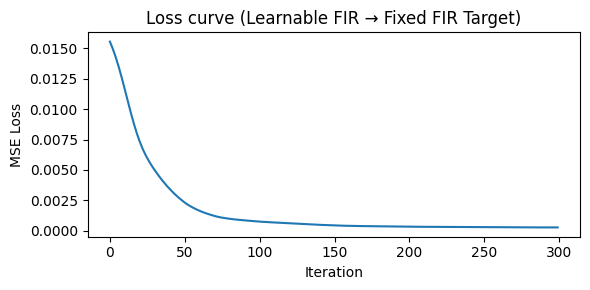

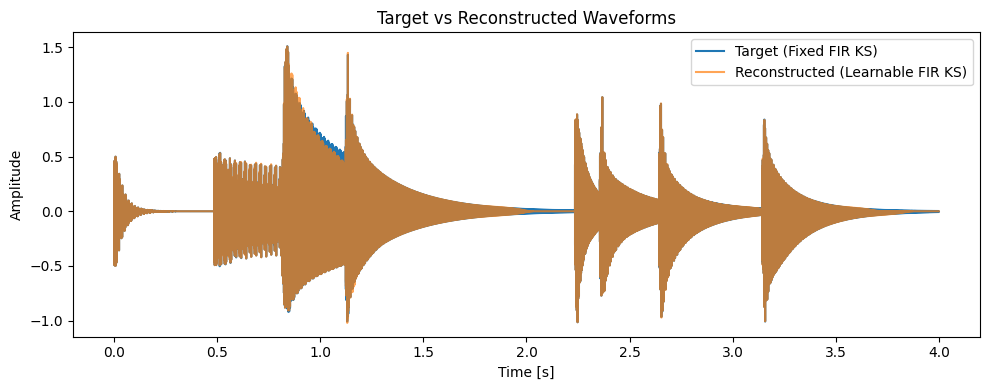


▶ Target signal (Fixed FIR KS)



▶ Reconstructed (Learnable FIR KS)


In [23]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from ddsp.diff_ks import DiffKSFIRLoopLearnableCoefficients

# --- Select reference output (multi noise + dynamic f0 + dynamic (p,g)) ---
target_index = 7  # 8th combination (0-based index)
target_title, y_target = outputsFIR[target_index]
print(f"🎯 Training target: {target_title}")

# --- Model ---
fir_karplus_model = DiffKSFIRLoopLearnableCoefficients().to(torch.float32)

# --- Input and controls ---
f0_target = (SAMPLE_RATE / f0_dynamic).unsqueeze(0)  # [1, N]
x_input = burst_multi.unsqueeze(0)  # [1, N]

# --- Trainable logits for p and g ---
logits = nn.Parameter(torch.zeros((1, n_samples, 2)))  # [1, N, 2]
optimizer = optim.Adam([logits], lr=1e-1)

# --- Training loop ---
num_iters = 300
loss_history = []

y_target = y_target.unsqueeze(0).to(torch.float32)

pbar = tqdm(range(num_iters), desc="Training Learnable FIR KS", ncols=100)
for i in pbar:
    optimizer.zero_grad()
    y_pred = fir_karplus_model(f0=f0_target, input=x_input, l_b=logits)
    loss = torch.mean((y_pred - y_target) ** 2)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    pbar.set_postfix({"loss": f"{loss.item():.6f}"})

# --- Final output ---
y_out = y_pred.detach().cpu()[0]
y_tgt = y_target.detach().cpu()[0]

def plot_loss_curve(loss_history, title="Loss Curve", ylabel="MSE Loss"):
    plt.figure(figsize=(6, 3))
    plt.plot(loss_history)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

plot_loss_curve(loss_history, title="Loss curve (Learnable FIR → Fixed FIR Target)")

# --- Plot waveforms ---
t = torch.arange(n_samples) / SAMPLE_RATE
plt.figure(figsize=(10, 4))
plt.plot(t, y_tgt, label="Target (Fixed FIR KS)")
plt.plot(t, y_out, label="Reconstructed (Learnable FIR KS)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Target vs Reconstructed Waveforms")
plt.tight_layout()
plt.show()

# --- Audio playback ---
print("\n▶ Target signal (Fixed FIR KS)")
display(Audio(y_tgt, rate=SAMPLE_RATE))

print("\n▶ Reconstructed (Learnable FIR KS)")
display(Audio(y_out, rate=SAMPLE_RATE))

## Learning Coefficients (IIR)


🎯 Training target (IIR model): Multi noise + Dynamic f0 + Dynamic (p,g)


Training Learnable IIR KS: 100%|███████████████████| 300/300 [00:31<00:00,  9.51it/s, loss=0.003016]


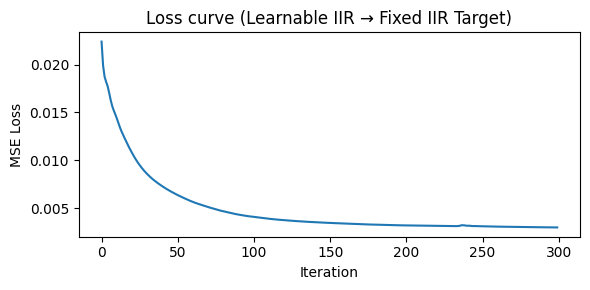

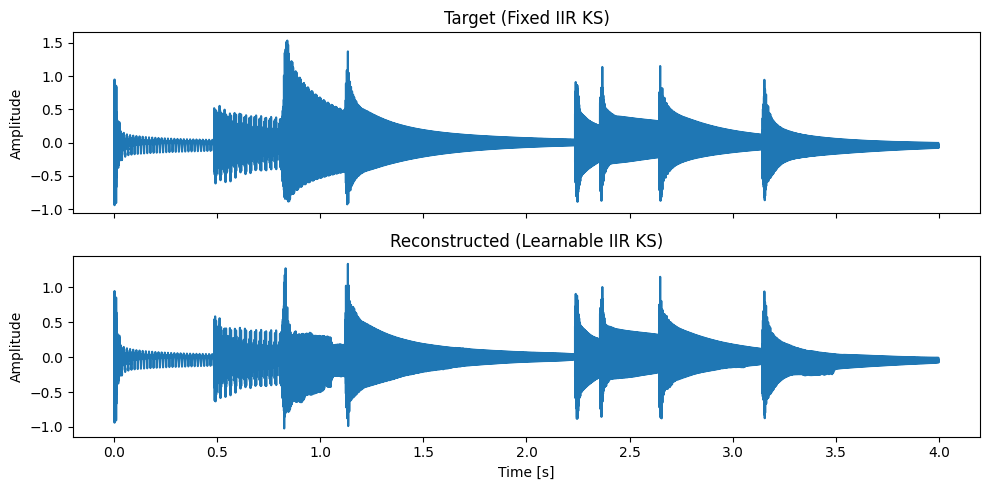


▶ Target signal (Fixed IIR KS)



▶ Reconstructed (Learnable IIR KS)


In [24]:
from ddsp.diff_ks import DiffKSIIRLoopLearnableCoefficients

# --- Select reference output (multi noise + dynamic f0 + dynamic (p,g)) ---
target_title, y_target = outputsIIR[target_index]
print(f"🎯 Training target (IIR model): {target_title}")

# --- Model ---
iir_karplus_model = DiffKSIIRLoopLearnableCoefficients().to(torch.float32)

# --- Trainable logits for p and g ---
logits = nn.Parameter(torch.zeros((1, n_samples, 2)))  # [1, N, 2]
optimizer = optim.Adam([logits], lr=1e-1)

# --- Training loop ---
num_iters = 300
loss_history = []

y_target = y_target.unsqueeze(0).to(torch.float32)

pbar = tqdm(range(num_iters), desc="Training Learnable IIR KS", ncols=100)
for i in pbar:
    optimizer.zero_grad()
    y_pred = iir_karplus_model(f0=f0_target, input=x_input, l_b=logits)
    loss = torch.mean((y_pred - y_target) ** 2)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    pbar.set_postfix({"loss": f"{loss.item():.6f}"})

# --- Final output ---
y_out = y_pred.detach().cpu()[0]
y_tgt = y_target.detach().cpu()[0]

# --- Plot loss ---
plot_loss_curve(loss_history, title="Loss curve (Learnable IIR → Fixed IIR Target)")

# --- Plot waveforms ---
plot_waveforms(
    signals=[y_tgt, y_out],
    titles=["Target (Fixed IIR KS)", "Reconstructed (Learnable IIR KS)"],
    sample_rate=SAMPLE_RATE
)

# --- Audio playback ---
print("\n▶ Target signal (Fixed IIR KS)")
display(Audio(y_tgt, rate=SAMPLE_RATE))

print("\n▶ Reconstructed (Learnable IIR KS)")
display(Audio(y_out, rate=SAMPLE_RATE))